# Data Preparation for Deep Learning

In this very first run, we will try to ignore DNS entries and try to ascertain if knowledge of the MAC address
and OUI as well as other session summary information is sufficient to get our model to converge with sufficient accuracy. I think that if we can get > 70% prediction that a session summary entry is IoT then we win.  

Also, for the first run we will only try to predict that the session info is pertaining to an IoT packet.  We will try to classify later.

In [1]:
from pathlib import Path
import os
import re
import apsw
import pandas as pd
import time
import pprint


In [2]:
cwd = Path.cwd()
db_path = os.path.join(cwd.parent, 'Data', 'NetCollector.sqlite')


The following query relies on the existence of the following view in the database

`create view if not exists v_session_mnf_devicetype as
select sessionid, manufacturer, device_type from devicelog group by sessionid`

In [3]:
conn = apsw.Connection(db_path)
cur = conn.cursor()

sql = """
-- We still have the smell on some endtime entries being less than
-- some starttime entries

select s.srcport,
       s.dstport,
       s.lensum,
       s.pktcount,
       s.endtime - s.starttime as durn, -- SMELL --
       d.manufacturer,
       d.device_type
from sessions s
         inner join v_session_mnf_devicetype d on s.sessionid = d.sessionid
where d.device_type is not null

"""


In [4]:
arr = []
for row in cur.execute(sql):
    arr.append(row)


In [5]:
cols = ['SourcePort',
        'DestnPort',
        'SessionPackets',
        'SessionPktLen',
        'SessionPktArrivalTime',
        'Manufacturer',
        'DeviceType']
df = pd.DataFrame(data=arr, columns=cols)

In [6]:
df.describe()

,SessionPackets,SessionPktLen,SessionPktArrivalTime
count,9.688000e+03,9688.000000,9688.000000
mean,2.904122e+05,349.180429,6.928621
std,1.106329e+07,8618.014923,132.783338
min,6.000000e+01,1.000000,-2039.997730
25%,2.420000e+02,2.000000,0.000000
50%,1.178000e+03,6.000000,0.758710
75%,3.627250e+03,13.000000,18.063444
max,7.402338e+08,496770.000000,2088.069581


# What we will do

The following is done next...

1. Normalise the values in place (all non-categorical is between 0 and 1)
2. Create category maps for `Manufacturer`
3. Drop features that we are not going to use in our model (i.e. `SourcePort`, `DestnPort`)
3. We will create an `is_iot` feature to try to initially train our model to distinguish only if a given record describing one session's worth of packets relates to an IOT device. This will be our `y-value` initially





In [7]:
df

,SourcePort,DestnPort,SessionPackets,SessionPktLen,SessionPktArrivalTime,Manufacturer,DeviceType
0,55630,63960,36384156,126998,-419.030715,Ubiquiti Networks Inc.,Other
1,63960,55630,9039457,125631,-419.074508,"Apple, Inc.",Other
2,49322,7550,306906857,228847,-419.074864,Ubiquiti Networks Inc.,UVC-G3-Flex Camera
3,49323,7550,84313180,83489,-419.072925,Ubiquiti Networks Inc.,UVC-G3-Flex Camera
4,443,58235,18288,127,-434.025740,Ubiquiti Networks Inc.,Other
...,...,...,...,...,...,...,...
9683,53,61777,151,1,0.000000,Ubiquiti Networks Inc.,Other
9684,55463,443,1999,5,0.203312,Technicolor CH USA Inc.,Other
9685,443,55463,1840,6,0.175634,Ubiquiti Networks Inc.,Other
9686,54459,53,87,1,0.000000,Intel Corporate,Other


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9688 entries, 0 to 9687
Data columns (total 7 columns):
SourcePort               9688 non-null object
DestnPort                9688 non-null object
SessionPackets           9688 non-null int64
SessionPktLen            9688 non-null int64
SessionPktArrivalTime    9688 non-null float64
Manufacturer             9688 non-null object
DeviceType               9688 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 529.9+ KB


In the first `1000000` session entries there are only `52` DNS packets... let's try to learn without these

In [9]:
import numpy as np
df['is_iot'] = np.where(df['DeviceType'] == 'Other', 0, 1)


In [10]:
df.head()

,SourcePort,DestnPort,SessionPackets,SessionPktLen,SessionPktArrivalTime,Manufacturer,DeviceType,is_iot
0,55630,63960,36384156,126998,-419.030715,Ubiquiti Networks Inc.,Other,0
1,63960,55630,9039457,125631,-419.074508,"Apple, Inc.",Other,0
2,49322,7550,306906857,228847,-419.074864,Ubiquiti Networks Inc.,UVC-G3-Flex Camera,1
3,49323,7550,84313180,83489,-419.072925,Ubiquiti Networks Inc.,UVC-G3-Flex Camera,1
4,443,58235,18288,127,-434.025740,Ubiquiti Networks Inc.,Other,0


In [11]:
drop_columns = ['SourcePort', 'DestnPort', 'DeviceType']

In [12]:
df.drop(drop_columns, axis=1, inplace=True)

In [13]:
df

,SessionPackets,SessionPktLen,SessionPktArrivalTime,Manufacturer,is_iot
0,36384156,126998,-419.030715,Ubiquiti Networks Inc.,0
1,9039457,125631,-419.074508,"Apple, Inc.",0
2,306906857,228847,-419.074864,Ubiquiti Networks Inc.,1
3,84313180,83489,-419.072925,Ubiquiti Networks Inc.,1
4,18288,127,-434.025740,Ubiquiti Networks Inc.,0
...,...,...,...,...,...
9683,151,1,0.000000,Ubiquiti Networks Inc.,0
9684,1999,5,0.203312,Technicolor CH USA Inc.,0
9685,1840,6,0.175634,Ubiquiti Networks Inc.,0
9686,87,1,0.000000,Intel Corporate,0


In [14]:
for entry in sorted(df['Manufacturer'].unique()):
    print(entry)

Amazon Technologies Inc.
Apple, Inc.
AzureWave Technology Inc.
Beijing LT Honway Technology Co.,Ltd
Google, Inc.
Hewlett Packard
Intel Corporate
Murata Manufacturing Co., Ltd.
Raspberry Pi Foundation
Realtek Semiconductor Corp.
Rivet Networks
Samsung Electro-Mechanics(Thailand)
Technicolor CH USA Inc.
Topwell International Holdinds Limited
Ubiquiti Networks Inc.


In [15]:
# This is based on the superset from all records in the database
# the result above is from limiting our dataset to only 10,000
# sessions worth of data

mans = """
Amazon Technologies Inc.
Apple, Inc.
AzureWave Technology Inc.
Beijing LT Honway Technology Co.,Ltd
Google, Inc.
Hewlett Packard
Intel Corporate
Murata Manufacturing Co., Ltd.
Raspberry Pi Foundation
Realtek Semiconductor Corp.
Rivet Networks
Samsung Electro-Mechanics(Thailand)
Technicolor CH USA Inc.
Topwell International Holdinds Limited
Ubiquiti Networks Inc.
""".splitlines()

mapping = {k: v for v, k in enumerate((x for x in mans if len(x)>0),1)}
print(mapping)

{'Amazon Technologies Inc.': 1, 'Apple, Inc.': 2, 'AzureWave Technology Inc.': 3, 'Beijing LT Honway Technology Co.,Ltd': 4, 'Google, Inc.': 5, 'Hewlett Packard': 6, 'Intel Corporate': 7, 'Murata Manufacturing Co., Ltd.': 8, 'Raspberry Pi Foundation': 9, 'Realtek Semiconductor Corp.': 10, 'Rivet Networks': 11, 'Samsung Electro-Mechanics(Thailand)': 12, 'Technicolor CH USA Inc.': 13, 'Topwell International Holdinds Limited': 14, 'Ubiquiti Networks Inc.': 15}


**Categorical data mapping**

For the deep learning algorithm to work, we need to get rid of all categorical data.  For the Manufacturer's we will create a 1:1 mapping of the manufacturer name as per the wireshark OUI lookup dataset and the relative
position of that in our ordered array of unique entries

In [16]:
df['Manufacturer'] = df['Manufacturer'].map(mapping)

In [17]:
df.head()

,SessionPackets,SessionPktLen,SessionPktArrivalTime,Manufacturer,is_iot
0,36384156,126998,-419.030715,15,0
1,9039457,125631,-419.074508,2,0
2,306906857,228847,-419.074864,15,1
3,84313180,83489,-419.072925,15,1
4,18288,127,-434.025740,15,0


In [18]:
df['SessionPackets'] = (df['SessionPackets'] - df['SessionPackets'].mean()) / \
    (df['SessionPackets'].max() - df['SessionPackets'].min())

In [19]:
df['SessionPktLen'] = (df['SessionPktLen'] - df['SessionPktLen'].mean()) / \
    (df['SessionPktLen'].max() - df['SessionPktLen'].min())

In [20]:
df['SessionPktArrivalTime'] = (df['SessionPktArrivalTime'] - df['SessionPktArrivalTime'].mean()) / \
    (df['SessionPktArrivalTime'].max() - df['SessionPktArrivalTime'].min())

In [21]:
df

,SessionPackets,SessionPktLen,SessionPktArrivalTime,Manufacturer,is_iot
0,0.048760,0.254945,-0.103186,15,0
1,0.011819,0.252193,-0.103197,2,0
2,0.414216,0.459968,-0.103197,15,1
3,0.113508,0.167361,-0.103196,15,1
4,-0.000368,-0.000447,-0.106819,15,0
...,...,...,...,...,...
9683,-0.000392,-0.000701,-0.001678,15,0
9684,-0.000390,-0.000693,-0.001629,13,0
9685,-0.000390,-0.000691,-0.001636,15,0
9686,-0.000392,-0.000701,-0.001678,7,0


# Machine learning - session 1

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures

The first model will be pretty basic and will only be able to `predict` if session data corresponds to an IoT device or not.

Later runs will refine the model to try to predict the device name from the data that we pass to it.  The DNN will be compriosed of the following layers:

[Input Layer: 4 inputs] -> [Hidden layer 1: 32 nodes] -> [Hidden layer 2: 64 nodes] -> [Hidden layer 3: 32 nodes] -> [Output layer: 1 output]

the `relu` activation function defined as f(x) = max(0, x) will be used for each layer apart from the last layer which will use the sigmoid function.  The adam optimiser will be used and the loss function will be the binary_crossentropy which is best for binary classification problems.


In [22]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [23]:
features = df.drop('is_iot', axis=1).values

In [24]:
labels = df['is_iot'].values

In [25]:
labels

array([0, 0, 1, ..., 0, 0, 0])

In [26]:
features

array([[ 4.87599300e-02,  2.54945094e-01, -1.03186141e-01,
         1.50000000e+01],
       [ 1.18193007e-02,  2.52193312e-01, -1.03196750e-01,
         2.00000000e+00],
       [ 4.14215728e-01,  4.59967952e-01, -1.03196836e-01,
         1.50000000e+01],
       ...,
       [-3.89839273e-04, -6.90824970e-04, -1.63587142e-03,
         1.50000000e+01],
       [-3.92207444e-04, -7.00890010e-04, -1.67841770e-03,
         7.00000000e+00],
       [-3.91988594e-04, -7.00890010e-04, -1.67841770e-03,
         1.50000000e+01]])

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [28]:
print(len(labels), len(Y_train), len(Y_test), sep='::')

9688::7750::1938


# Classification Problems

*A quick recap of the various hyper-parameters to be used in the model for each type of classification problem:*

**Binary Classification Problem**

A problem where you classify an example as belonging to one of two classes.

The problem is framed as predicting the likelihood of an example belonging to class one, e.g. the class that you assign the integer value 1, whereas the other class is assigned the value 0.

 - Output Layer Configuration: `One node with a sigmoid activation unit`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

**Multi-Class Classification Problem**

A problem where you classify an example as belonging to one of more than two classes.

The problem is framed as predicting the likelihood of an example belonging to each class.

 - Output Layer Configuration: `One node for each class using the softmax activation function`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

In [29]:
from keras.models import Sequential
from keras.layers import *

Using TensorFlow backend.


In [30]:
model = Sequential()
model.add(Dense(32, input_dim=4, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
model.compile(loss= 'mse' , optimizer= 'adam' , metrics=['accuracy'])

In [31]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=10, shuffle=True, verbose=2)

Epoch 1/20
 - 1s - loss: 0.1245 - accuracy: 0.8542
Epoch 2/20
 - 0s - loss: 0.1223 - accuracy: 0.8542
Epoch 3/20
 - 0s - loss: 0.1218 - accuracy: 0.8542
Epoch 4/20
 - 0s - loss: 0.1207 - accuracy: 0.8542
Epoch 5/20
 - 0s - loss: 0.1195 - accuracy: 0.8542
Epoch 6/20
 - 0s - loss: 0.1186 - accuracy: 0.8551
Epoch 7/20
 - 0s - loss: 0.1175 - accuracy: 0.8554
Epoch 8/20
 - 0s - loss: 0.1161 - accuracy: 0.8564
Epoch 9/20
 - 0s - loss: 0.1138 - accuracy: 0.8572
Epoch 10/20
 - 0s - loss: 0.1122 - accuracy: 0.8655
Epoch 11/20
 - 1s - loss: 0.1106 - accuracy: 0.8672
Epoch 12/20
 - 0s - loss: 0.1098 - accuracy: 0.8672
Epoch 13/20
 - 0s - loss: 0.1089 - accuracy: 0.8668
Epoch 14/20
 - 0s - loss: 0.1074 - accuracy: 0.8672
Epoch 15/20
 - 0s - loss: 0.1062 - accuracy: 0.8670
Epoch 16/20
 - 0s - loss: 0.1029 - accuracy: 0.8741
Epoch 17/20
 - 0s - loss: 0.0995 - accuracy: 0.8915
Epoch 18/20
 - 0s - loss: 0.0961 - accuracy: 0.8943
Epoch 19/20
 - 0s - loss: 0.0939 - accuracy: 0.8960
Epoch 20/20
 - 0s - l

# Cross-Entropy Loss (or Log Loss)


Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or 
“log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that 
penalizes the probability based on the distance from the expected value. The penalty is logarithmic, 
offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. 
A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average 
cross entropy across all examples.

The Python function below provides a pseudocode-like working implementation of a function for calculating 
the cross-entropy for a list of actual 0 and 1 values compared to predicted probabilities for the class 1.

<code>
from math import log

def binary_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		sum_score += actual[i] * log(1e-15 + predicted[i])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score
</code>

In [32]:
model.metrics_names

['loss', 'accuracy']

In [33]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)

In [34]:
print(f'Loss = {loss}, Accuracy={accuracy}')

Loss = 0.0917564487032846, Accuracy=0.8952528238296509


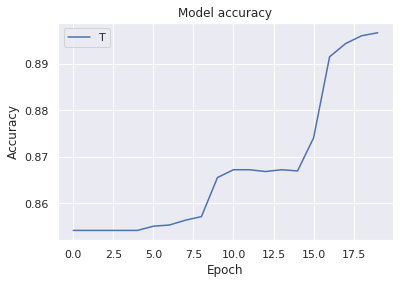

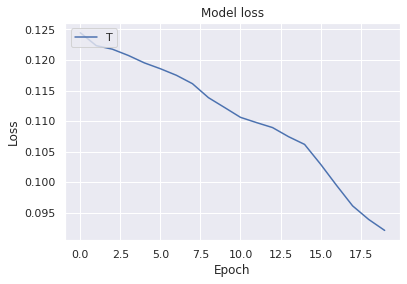

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

In [66]:
import pandas_profiling
pandas_profiling.ProfileReport(df)